### Import the Libraries

In [1]:
import os
import math
import pandas as pd
import numpy as np

import librosa
import librosa.display

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

import tensorflow.keras as keras
import tensorflow as tf

from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential
from tensorflow.python.keras import regularizers

data_path = '../audio_data_MFCC/10_segs_per_track_output.npz'

### Load and prepare the data

In [2]:
def load_data (dataset_path, data1 = 'mfcc', data2 = 'labels'):
    
    np_file = np.load(dataset_path)
    
    return np_file[data1], np_file[data2]

In [3]:
def prepare_datasets(data_path, test_size, validation_size):
    
    # load data
    X, y = load_data(data_path, 'mfcc', 'labels')
    
    # create train test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size)
    
    
    # create train/validation split
    X_train, X_validation, y_train, y_validation = train_test_split(X_train, 
                                                                    y_train, 
                                                                    test_size=validation_size)
    
    
    X_train = X_train[..., np.newaxis] # 4d array -> (num_samples, 130, 13, 1)
    X_validation = X_validation[..., np.newaxis]
    X_test = X_test[..., np.newaxis]
    
    return X_train, X_validation, X_test, y_train, y_validation, y_test
    

In [4]:
X_train, X_validation, X_test, y_train, y_validation, y_test = prepare_datasets('../audio_data_MFCC/6_segs_per_track_output.npz', 0.25, 0.2)

### Define and build the model

In [5]:
def build_model(input_shape):

    model = keras.Sequential()

    # 1st conv layer
    model.add(keras.layers.Conv2D(64, (3, 3), activation='relu', input_shape=input_shape))
    model.add(keras.layers.MaxPooling2D((3, 3), strides=(2, 2), padding='same'))
    model.add(keras.layers.BatchNormalization())

    # 2nd conv layer
    model.add(keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.01)))
    model.add(keras.layers.MaxPooling2D((3, 3), strides=(2, 2), padding='same'))
    model.add(keras.layers.Dropout(0.25))
    model.add(keras.layers.BatchNormalization())

    # 3rd conv layer
    model.add(keras.layers.Conv2D(32, (2, 2), activation='relu'))
    model.add(keras.layers.MaxPooling2D((2, 2), strides=(2, 2), padding='same'))
    model.add(keras.layers.Dropout(0.25))
    model.add(keras.layers.BatchNormalization())
    
    # 3rd conv layer
    model.add(keras.layers.Conv2D(16, (1, 1), activation='relu'))
    model.add(keras.layers.MaxPooling2D((2, 2), strides=(2, 2), padding='same'))
    model.add(keras.layers.BatchNormalization())

    # flatten output and feed it into dense layer
    model.add(keras.layers.Flatten())
    model.add(keras.layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
    model.add(keras.layers.Dropout(0.5))
    model.add(keras.layers.Dense(32, activation='relu', kernel_regularizer=regularizers.l2(0.001)))

    # output layer
    model.add(keras.layers.Dense(10, activation='softmax'))
    
    return model

In [6]:
X_train.shape

(3595, 216, 13, 1)

### Build and Compile The Model

In [7]:
# build CNN model
input_shape = (X_train.shape[1], X_train.shape[2], X_train.shape[3])
model = build_model(input_shape)

In [8]:
# compile model
optimizer = keras.optimizers.Adam(learning_rate = 0.00015)
model.compile(optimizer=optimizer,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

### Add in an early stop to avoid overtraining

In [9]:
early_stop = EarlyStopping(monitor='accuracy', mode='min', verbose=1, patience=25)

In [10]:
history = model.fit(X_train, 
          y_train, 
          validation_data = (X_validation, y_validation), 
          batch_size = 64, 
          epochs = 150,
          )

# history = model.fit(X_train, 
#           y_train, 
#           validation_data = (X_validation, y_validation), 
#           batch_size = 64, 
#           epochs = 200,
#           callbacks = [early_stop])

Epoch 1/150
57/57 [==============================] - 24s 358ms/step - loss: 3.7112 - accuracy: 0.0960 - val_loss: 3.1894 - val_accuracy: 0.0923
Epoch 2/150
57/57 [==============================] - 16s 289ms/step - loss: 3.3490 - accuracy: 0.1230 - val_loss: 2.9640 - val_accuracy: 0.1935
Epoch 3/150
57/57 [==============================] - 16s 288ms/step - loss: 3.1837 - accuracy: 0.1622 - val_loss: 2.8841 - val_accuracy: 0.2136
Epoch 4/150
57/57 [==============================] - 17s 294ms/step - loss: 3.0155 - accuracy: 0.2097 - val_loss: 2.8206 - val_accuracy: 0.2747
Epoch 5/150
57/57 [==============================] - 17s 291ms/step - loss: 2.9349 - accuracy: 0.2149 - val_loss: 2.7620 - val_accuracy: 0.3070
Epoch 6/150
57/57 [==============================] - 17s 295ms/step - loss: 2.8195 - accuracy: 0.2576 - val_loss: 2.6868 - val_accuracy: 0.3359
Epoch 7/150
57/57 [==============================] - 17s 291ms/step - loss: 2.6962 - accuracy: 0.2868 - val_loss: 2.5993 - val_accuracy:

57/57 [==============================] - 17s 290ms/step - loss: 1.2205 - accuracy: 0.7081 - val_loss: 1.7230 - val_accuracy: 0.5373
Epoch 58/150
57/57 [==============================] - 16s 288ms/step - loss: 1.2449 - accuracy: 0.6879 - val_loss: 1.4167 - val_accuracy: 0.6185
Epoch 59/150
57/57 [==============================] - 16s 288ms/step - loss: 1.1884 - accuracy: 0.7251 - val_loss: 1.5516 - val_accuracy: 0.5662
Epoch 60/150
57/57 [==============================] - 16s 286ms/step - loss: 1.1756 - accuracy: 0.7170 - val_loss: 1.5099 - val_accuracy: 0.5918
Epoch 61/150
57/57 [==============================] - 16s 287ms/step - loss: 1.1916 - accuracy: 0.7162 - val_loss: 1.5342 - val_accuracy: 0.5818
Epoch 62/150
57/57 [==============================] - 16s 285ms/step - loss: 1.1525 - accuracy: 0.7292 - val_loss: 1.2955 - val_accuracy: 0.6607
Epoch 63/150
57/57 [==============================] - 18s 316ms/step - loss: 1.1757 - accuracy: 0.7077 - val_loss: 1.2145 - val_accuracy: 0.703

57/57 [==============================] - 16s 278ms/step - loss: 0.7599 - accuracy: 0.8335 - val_loss: 1.0245 - val_accuracy: 0.7686
Epoch 114/150
57/57 [==============================] - 16s 278ms/step - loss: 0.8222 - accuracy: 0.8147 - val_loss: 1.0422 - val_accuracy: 0.7608
Epoch 115/150
57/57 [==============================] - 16s 278ms/step - loss: 0.8074 - accuracy: 0.8138 - val_loss: 1.1364 - val_accuracy: 0.7264
Epoch 116/150
57/57 [==============================] - 16s 276ms/step - loss: 0.7828 - accuracy: 0.8341 - val_loss: 1.1074 - val_accuracy: 0.7497
Epoch 117/150
57/57 [==============================] - 16s 280ms/step - loss: 0.7526 - accuracy: 0.8421 - val_loss: 0.9119 - val_accuracy: 0.7920
Epoch 118/150
57/57 [==============================] - 16s 282ms/step - loss: 0.7749 - accuracy: 0.8365 - val_loss: 1.1048 - val_accuracy: 0.7375
Epoch 119/150
57/57 [==============================] - 16s 281ms/step - loss: 0.7464 - accuracy: 0.8399 - val_loss: 1.0505 - val_accuracy:

In [11]:
test_error, test_accuracy = model.evaluate(X_test, y_test, verbose=1)

47/47 [==============================] - 1s 19ms/step - loss: 0.7992 - accuracy: 0.8238


### Plot the Accuracy and Loss

In [15]:
def plot_model(history):
    fig, axs = plt.subplots(2)

    # Accuracy Subplot
    axs[0].plot(history.history["accuracy"], label="train accuracy")
    axs[0].plot(history.history["val_accuracy"], label="test accuracy")
    axs[0].set_ylabel("Accuracy")
    axs[0].legend(loc="lower right")
    axs[0].set_title("Accuracy Eval")

    # Error Subplot
    axs[1].plot(history.history["loss"], label="train error")
    axs[1].plot(history.history["val_loss"], label="test error")
    axs[1].set_ylabel("Error")
    axs[1].set_xlabel("Epoch")
    axs[1].legend(loc="upper right")
    axs[1].set_title("Error Eval")

    plt.show()

TypeError: 'History' object is not subscriptable

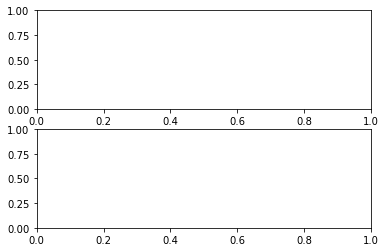

In [16]:
plot_model(model)

### Predict Model

In [28]:
def predict(model, X_prediction, y_prediction):
    
    X = X[np.newaxis, ...]
    
    # Plot predictions to a 2D Array
    predictions = model.predict(X_temp)
    
    predicted_index = np.argmax(predictions, axis=1)
    
    print(f'Target: {y}, Predicted label: {predicted_index}')

In [29]:
X_prediction = X_test[200]
y_prediction = y_test[200]

In [30]:
predict(model, X_prediction, y_prediction)

UnboundLocalError: local variable 'X' referenced before assignment

### Save The Model

In [20]:
model.save('../models/cnn_model_10_segs_per_track.h5')